In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import sweetviz as sv

import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# 特徴量チェック
def check(df):
    col_list = df.columns.values  # 列名を取得
    row = []
    for col in col_list:
        unique = ""
        value_counts = ""
        if df[col].nunique() < 12:
            unique = df[col].unique()
            value_counts = df[col].value_counts().to_dict()
        tmp = (
            col,  # 列名
            df[col].dtypes,  # データタイプ
            df[col].isnull().sum(),  # null数
            df[col].count(),  # データ数 (欠損値除く)
            df[col].nunique(),  # ユニーク値の数 (欠損値除く)
            unique,  # ユニーク値
            value_counts,  # ユニーク値のそれぞれの個数
        )
        row.append(tmp)  # tmpを順次rowに保存
    df = pd.DataFrame(row)  # rowをデータフレームの形式に変換
    df.columns = [
        "feature",
        "dtypes",
        "nan",
        "count",
        "num_unique",
        "unique",
        "unique_counts",
    ]  # データフレームの列名指定
    # unique_countsの中身確認のために横幅拡張
    d = dict(selector=".col8", props=[("min-width", "200px")])  # name
    # display(df.style.set_table_styles([d]))
    # display(df)
    return df.style.set_table_styles([d])

# データ読み込み

In [3]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [4]:
df_patient.shape, df_sample.shape

((2509, 24), (2509, 13))

In [5]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,ER_IHC,object,83,2426,2,['Positve' 'Negative' nan],"{'Positve': 1817, 'Negative': 609}"
7,HER2_SNP6,object,529,1980,4,['NEUTRAL' 'LOSS' nan 'GAIN' 'UNDEF'],"{'NEUTRAL': 1436, 'GAIN': 438, 'LOSS': 101, 'UNDEF': 5}"
8,HORMONE_THERAPY,object,529,1980,2,['YES' 'NO' nan],"{'YES': 1216, 'NO': 764}"
9,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"


## カラムの順序変更（読みやすさのため）

In [6]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [7]:
df_clinical.filter(regex="^ER|^HER2")

,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS
0,Positve,NEUTRAL,Positive,Negative
1,Positve,NEUTRAL,Positive,Negative
2,Positve,NEUTRAL,Positive,Negative
3,Positve,NEUTRAL,Positive,Negative
4,Positve,NEUTRAL,Positive,Negative
...,...,...,...,...
2504,Positve,NaN,Positive,NaN
2505,Positve,NaN,Positive,NaN
2506,NaN,NaN,NaN,NaN
2507,NaN,NaN,NaN,NaN


In [8]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*_THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

check(df_clinical)

,feature,dtypes,nan,count,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,32,,
2,NPI,float64,222,2287,436,,
3,CELLULARITY,object,592,1917,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,INFERRED_MENOPAUSAL_STATE,object,529,1980,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
7,SEX,object,0,2509,1,['Female'],{'Female': 2509}
8,INTCLUST,object,529,1980,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
9,AGE_AT_DIAGNOSIS,float64,11,2498,1843,,


In [9]:
# 重複カラム確認
# df_clinical.T.duplicated()
# SAMPLE_IDのみ（PATIENT_IDと重複している）

In [10]:
# データの型の定義（適用する前処理が大きく異なるため）

int_columns = [
    # patient
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "OS_MONTHS",
    "RFS_MONTHS",
]

float_columns = [
    # patient
    "NPI",
    "AGE_AT_DIAGNOSIS",
    # sample
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

str_columns = []

# 質的変数（順序尺度）
num_cat_columns = [
    # patient
    "CELLULARITY",
    "ER_IHC",
    "HER2_SNP6",
    "INFERRED_MENOPAUSAL_STATE",
    # sample
    "ER_STATUS",
    "HER2_STATUS",
    "GRADE",
    "PR_STATUS",
    "TUMOR_STAGE",
]
# 質的変数（名義尺度）
str_cat_columns = [
    # patient
    "COHORT",
    "INTCLUST",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "BREAST_SURGERY",
    "LATERALITY",
    "VITAL_STATUS",
    # sample
    "CANCER_TYPE",
    "CANCER_TYPE_DETAILED",
    "ONCOTREE_CODE",
]

bool_columns = [
    # patient
    "CHEMOTHERAPY",
    "HORMONE_THERAPY",
    "RADIO_THERAPY",
    "OS_STATUS",
    "RFS_STATUS",
]

meanless_columns = [
    # patient
    "PATIENT_ID",
    "SEX",
    # sample
    #'PATIENT_ID',
    "SAMPLE_ID",
    "SAMPLE_TYPE",
]

print(
    df_clinical.shape[1],
    len(int_columns)
    + len(float_columns)
    + len(str_columns)
    + len(num_cat_columns)
    + len(str_cat_columns)
    + len(bool_columns)
    + len(meanless_columns),
)
assert df_clinical.shape[1] == len(int_columns) + len(float_columns) + len(
    str_columns
) + len(num_cat_columns) + len(str_cat_columns) + len(bool_columns) + len(
    meanless_columns
), "lack or too much columns"

36 36


In [11]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [12]:
# save
make_dir(config.INTERIM_PICKLE_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

# 生存曲線の観察

lifelinesというライブラリがあったので、試してみる。
https://lifelines.readthedocs.io/en/latest/index.html

In [13]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [14]:
# PATIENT_IDにMBを含むデータのみ含むデータフレームを読み込み
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MB.shape

(1985, 36)

<AxesSubplot:xlabel='timeline'>

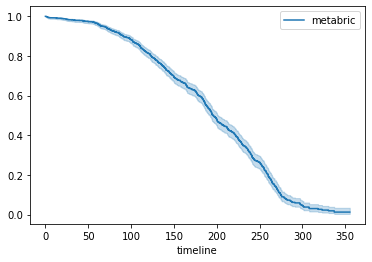

In [15]:
T = df_MB["OS_MONTHS"].dropna()
E = (
    df_MB["OS_STATUS"].dropna().map({"0:LIVING": 1, "1:DECEASED": 0})
)  # lifelinesを描くので、生存が1, 死亡が0

kmf = KaplanMeierFitter(label="metabric")
kmf.fit(T, E)
kmf.plot()